# Installing Dependencies and Libraries

In [ ]:
!pip install tensorflow keras opencv-python-headless pillow scikit-learn matplotlib

In [ ]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, BatchNormalization,
                                     Input, concatenate, add, Conv2D, MaxPooling2D,
                                     ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D)
from tensorflow.keras.utils import to_categorical, get_file
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16, InceptionV3
from sklearn.metrics import log_loss
import cv2
import os
from PIL import Image
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
import warnings

%matplotlib inline
warnings.simplefilter("ignore", UserWarning)


# Loading The Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rodrigov/deeper1")

print("Path to dataset files:", path)

100%|██████████| 293M/293M [00:03<00:00, 102MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rodrigov/deeper1/versions/1


# Reading Images and Seperating data for Training, Testing and Validation



In [ ]:
df=pd.read_csv("/root/.cache/kagglehub/datasets/rodrigov/deeper1/versions/1/train_rotfaces/train.truth.csv")
columns=["fn", "label"]

In [ ]:
df.head()

fn          label
0  0-10049200_1891-09-16_1958.jpg   rotated_left
1  0-10110600_1985-09-17_2012.jpg   rotated_left
2  0-10126400_1964-07-07_2010.jpg        upright
3   0-1013900_1917-10-15_1960.jpg  rotated_right
4  0-10166400_1960-03-12_2008.jpg    upside_down

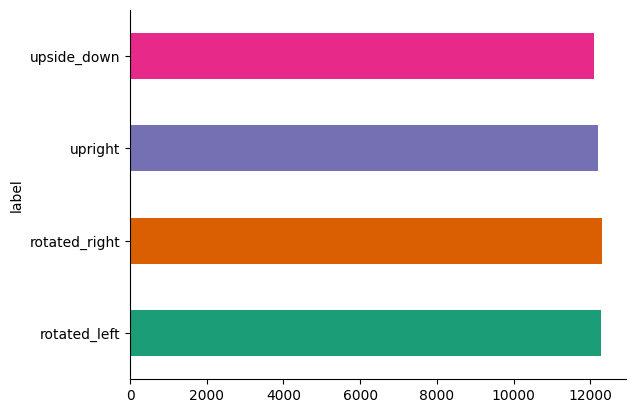

In [ ]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.shape[0]

48896

# Train Test Split

In [ ]:
# Define the indices for the split
train_df = df[:39117]
valid_df = df[39118:44006]
test_df = df[44007:]  # This part will be used as "test data" instead of a separate test directory.

# Data Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Train and validation datagen with rescaling (and optional augmentation for training if needed)
datagen = ImageDataGenerator(rescale=1./255.)

# Separate test datagen, only rescaling
test_datagen_final = ImageDataGenerator(rescale=1./255.)

# Train generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/root/.cache/kagglehub/datasets/rodrigov/deeper1/versions/1/train_rotfaces/train",
    x_col="fn",
    y_col="label",
    batch_size=32,
    seed=42,
    classes=['rotated_left', 'rotated_right', 'upright', 'upside_down'],
    shuffle=True,
    class_mode="categorical",
    target_size=(150, 150)
)

# Validation generator
valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory="/root/.cache/kagglehub/datasets/rodrigov/deeper1/versions/1/train_rotfaces/train",
    x_col="fn",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=True,
    classes=['rotated_left', 'rotated_right', 'upright', 'upside_down'],
    class_mode="categorical",
    target_size=(150, 150)
)

# Test generator (using a portion of train data as test set)
# Test generator (with labels included)
test_generator_final = test_datagen_final.flow_from_dataframe(
    dataframe=test_df,
    directory="/root/.cache/kagglehub/datasets/rodrigov/deeper1/versions/1/train_rotfaces/train",  # Same directory as train
    x_col="fn",   # Image filenames
    y_col="label",  # Labels
    target_size=(150, 150),
    batch_size=32,
    shuffle=False,  # No need to shuffle for test data
    class_mode="categorical"  # Ensure this is set to categorical to return labels
)

Found 39117 validated image filenames belonging to 4 classes.
Found 4888 validated image filenames belonging to 4 classes.
Found 4889 validated image filenames belonging to 4 classes.


In [ ]:
dic_name = train_generator.class_indices
dic_name
labels = ['rotated_left', 'rotated_right', 'upright', 'upside_down']

In [ ]:
train_generator.class_indices

{'rotated_left': 0, 'rotated_right': 1, 'upright': 2, 'upside_down': 3}

rotated_left


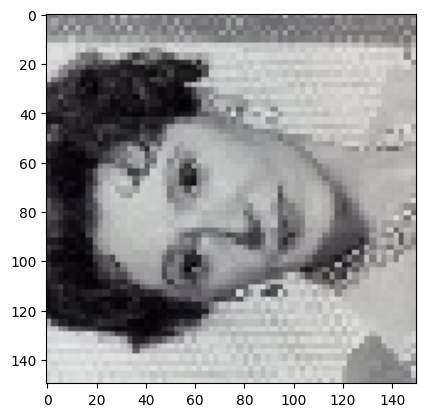

rotated_left


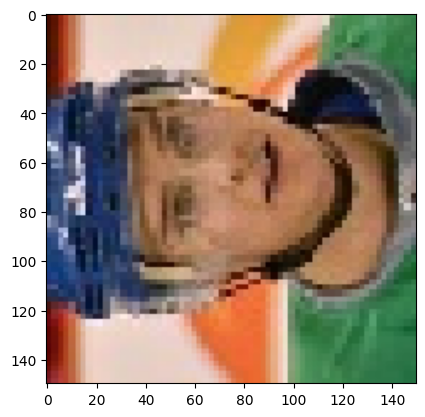

upright


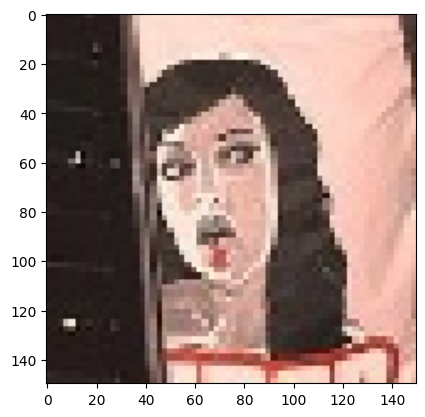

rotated_right


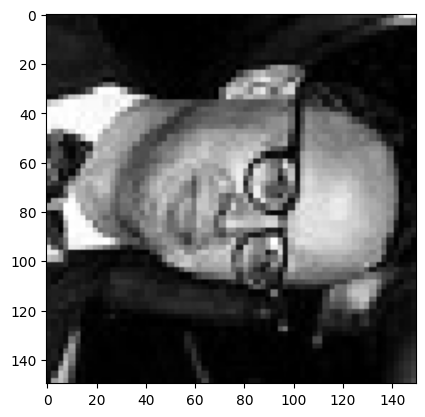

upside_down


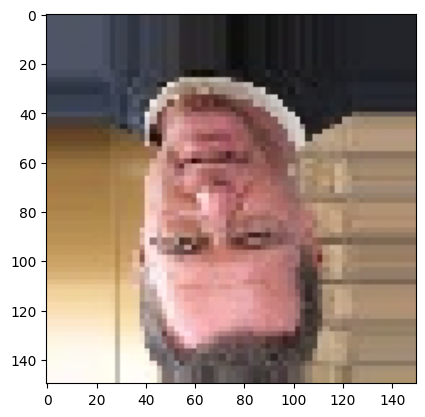

rotated_left


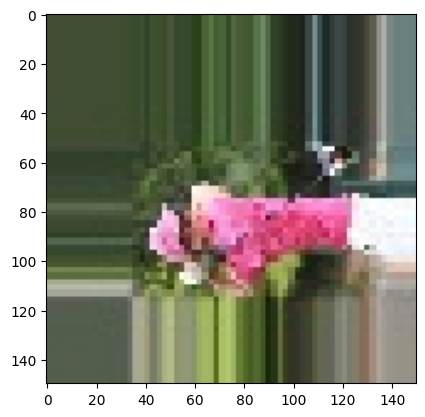

rotated_left


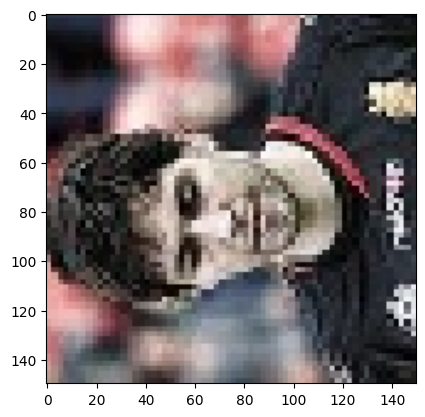

rotated_left


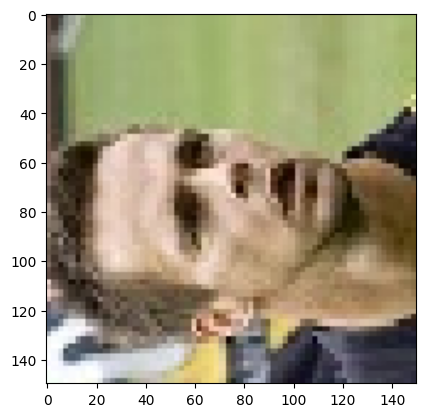

upside_down


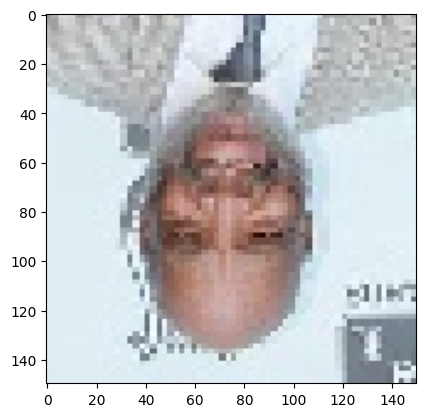

upright


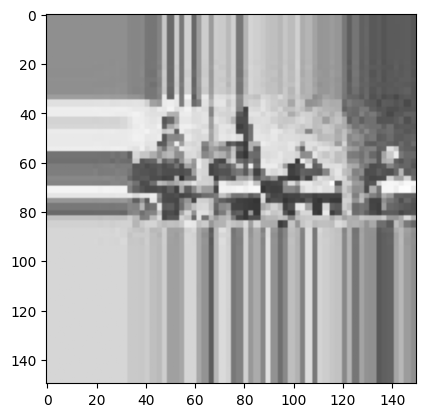

In [ ]:
paths = train_generator.filepaths
y_train = train_generator.classes

images = []
i = 0
for path in paths[:10]:
        img_path = path
        img = image.load_img(img_path, target_size=(150,150))
        x = image.img_to_array(img)
        images.append(x/255.)

for I, y in zip(images, y_train[:10] ):
    print(labels[y])
    plt.imshow(I)
    plt.show()

# Mobile-Net Model Creation and Training

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt

# Create MobileNet model
def create_mobilenet_model():
    input_layer = Input(shape=(150, 150, 3))
    mobilenet = MobileNet(include_top=False, weights='imagenet', input_tensor=input_layer)

    x = Flatten()(mobilenet.output)
    x = Dense(256, activation='relu')(x)
    output_layer = Dense(4, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    for layer in mobilenet.layers:
        layer.trainable = False

    adam = Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    print("Model Compiled Successfully.")
    print(model.summary())

    return model

In [ ]:
# Clear any previous session to avoid state issues
tf.keras.backend.clear_session()

# Now create the model
model = create_mobilenet_model()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Compiled Successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 75, 75, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 75, 75, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 75, 75, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 75, 75, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 75, 75, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 75, 75, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 76, 76, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 37, 37, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 37, 37, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 37, 37, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 37, 37, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 37, 37, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 37, 37, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 37, 37, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,424,452 (28.32 MB)

 Trainable params: 4,195,588 (16.00 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

None


In [ ]:
# Train MobileNet model
def train_model(model, train_generator, valid_generator, filepath, epochs=10, batch_size=300):
    print("Starting Model Training.")
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    n_train = 39117
    batch_size = 300
    n_valid = 9779

    try:
        history = model.fit(
            train_generator,
            steps_per_epoch=n_train // batch_size,
            epochs=epochs,
            validation_data=valid_generator,
            validation_steps=n_valid // batch_size,
            callbacks=callbacks_list
        )
        print("Model Training Completed Successfully.")
    except Exception as e:
        print(f"Error during training: {e}")
        return None

    # Plot
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epoch_range = range(1, len(acc) + 1)


    plt.plot(epoch_range, acc, 'b-', label='Training Accuracy')
    plt.plot(epoch_range, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.figure()

    plt.plot(epoch_range, loss, 'b-', label='Training Loss')
    plt.plot(epoch_range, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    return model


Starting Model Training.
Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.9001 - loss: 0.3157
Epoch 1: val_accuracy improved from -inf to 0.91797, saving model to mobilenet_weights.best.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 102s 778ms/step - accuracy: 0.9003 - loss: 0.3151 - val_accuracy: 0.9180 - val_loss: 0.2260
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9486 - loss: 0.1575
Epoch 2: val_accuracy improved from 0.91797 to 0.94629, saving model to mobilenet_weights.best.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 95s 732ms/step - accuracy: 0.9486 - loss: 0.1575 - val_accuracy: 0.9463 - val_loss: 0.1510
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.9620 - loss: 0.1305
Epoch 3: val_accuracy improved from 0.94629 to 0.95410, saving model to mobilenet_weights.best.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 96s 736ms/step - accuracy: 0.9620 - loss: 0.1305 - val_accuracy: 0.9541 - val_loss: 0.1259
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/s

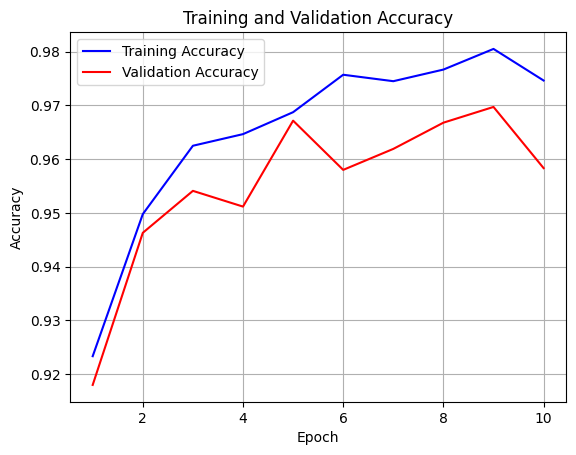

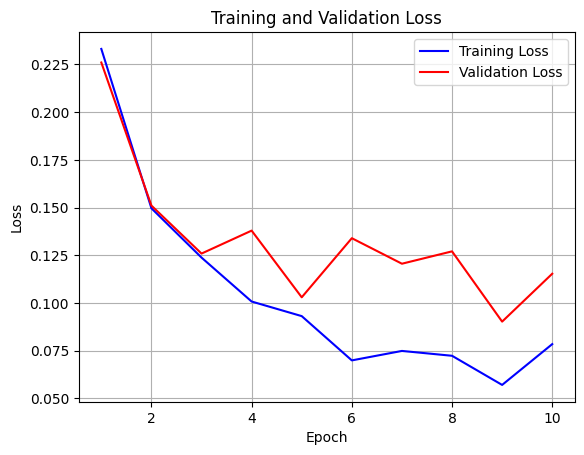

In [ ]:
# Train the model
batch_size = 300
model = train_model(model, train_generator, valid_generator, "mobilenet_weights.best.keras", epochs=10, batch_size=batch_size)

# Mobile-Net Model Evaluation

In [ ]:
# Evaluate the model using the test generator
model.evaluate(test_generator_final, steps=176, verbose=1)

176/176 ━━━━━━━━━━━━━━━━━━━━ 80s 457ms/step - accuracy: 0.9704 - loss: 0.0957


[0.09530360996723175, 0.9701370596885681]

# Mobile-Net Model Predictions

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Assuming test_generator_final has the correct file paths
paths = test_generator_final.filepaths[:20]  # Get the first 20 paths
labels = ['rotated_left', 'rotated_right', 'upright', 'upside_down']

y_pred = []
for path in paths:
    img_path = path
    img = image.load_img(img_path, target_size=(150, 150))  # Load image with the target size
    x = np.reshape(img, [1, 150, 150, 3])  # Reshape for the model input
    x = x / 255.0  # Normalize image to [0, 1]

    # Get prediction probabilities (output shape is (1, 4) for 4 classes)
    preds = model.predict(x)

    # Get the class with the highest probability (argmax)
    predicted_class = np.argmax(preds, axis=-1)[0]  # [0] to get the class label, not the array

    y_pred.append(labels[predicted_class])

# Print or use y_pred as needed
print("Predicted classes for the first 20 images:")
for i, pred in enumerate(y_pred):
    print(f"Image {i + 1}: {pred}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted classes for the first 20 images:
Image 1: upside_down
Image 2: rotated_right
Image 3: upright
Image 4: upside_down
Image 5: rotated_left
Image 6: upside_down
Image 7: upright
Image 8: upright
Image 9: upright
Image 10: rotated_le

In [ ]:
dic_name

{'rotated_left': 0, 'rotated_right': 1, 'upright': 2, 'upside_down': 3}

# Model Prediction Visulizations

Predicted class: upside_down


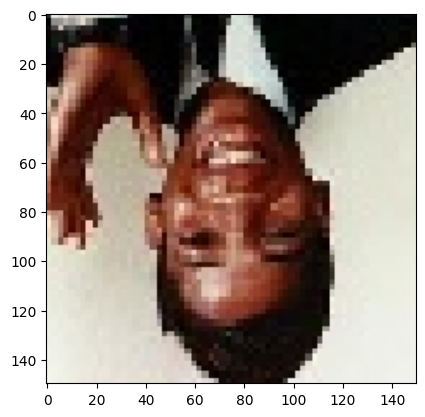

Predicted class: rotated_right


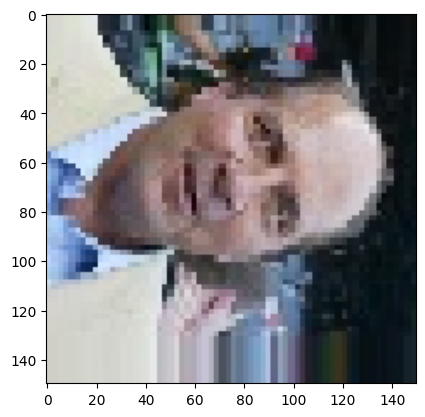

Predicted class: upright


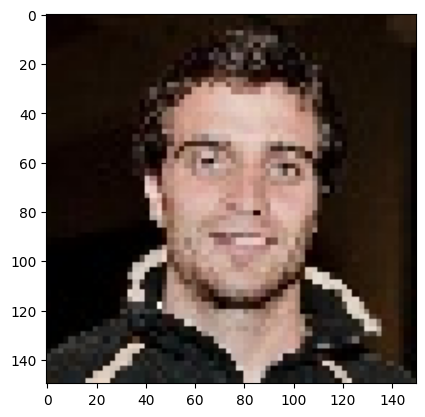

Predicted class: upside_down


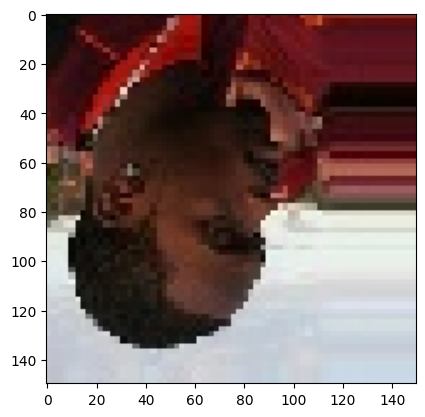

Predicted class: rotated_left


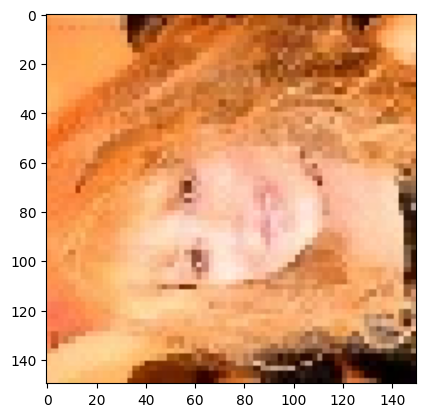

Predicted class: upside_down


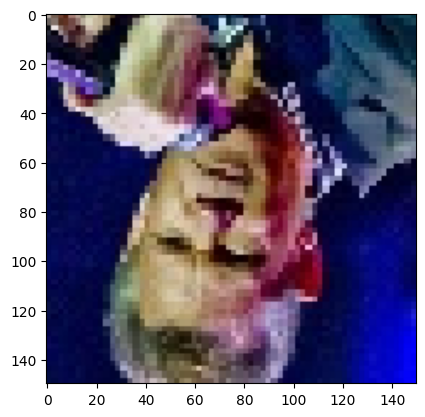

Predicted class: upright


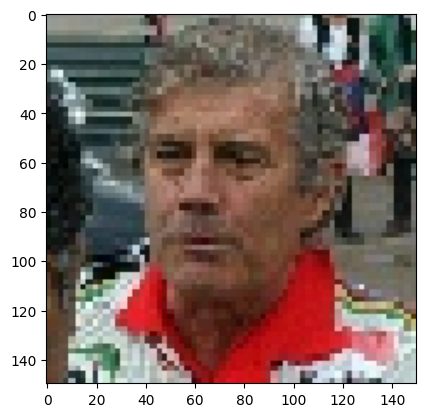

Predicted class: upright


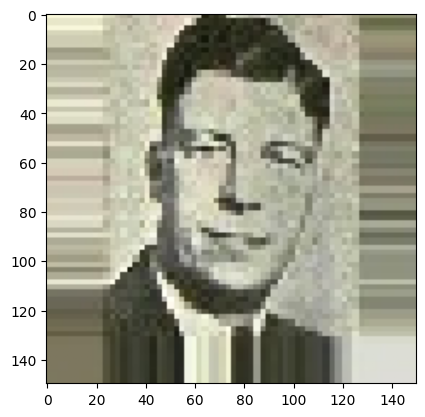

Predicted class: upright


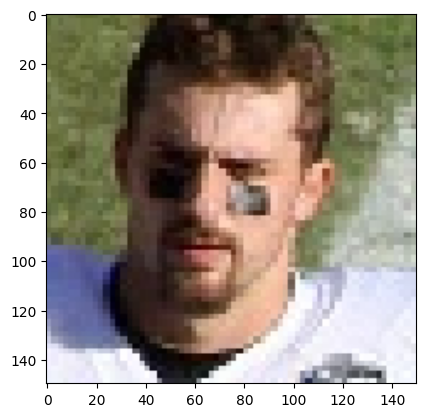

Predicted class: rotated_left


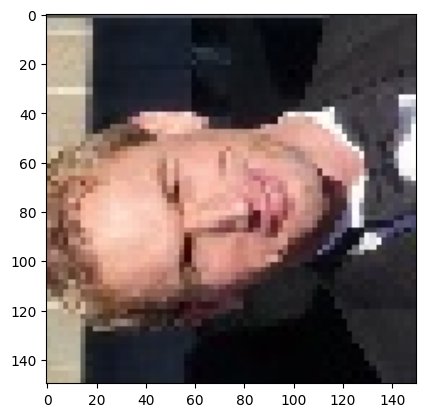

Predicted class: upside_down


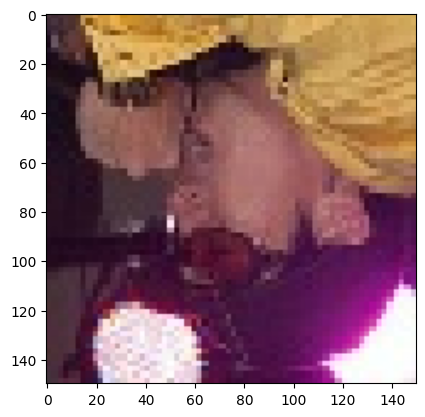

Predicted class: upright


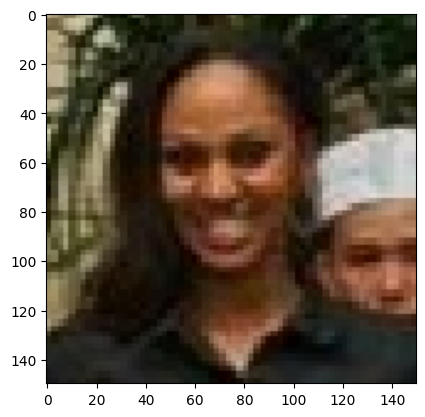

Predicted class: rotated_right


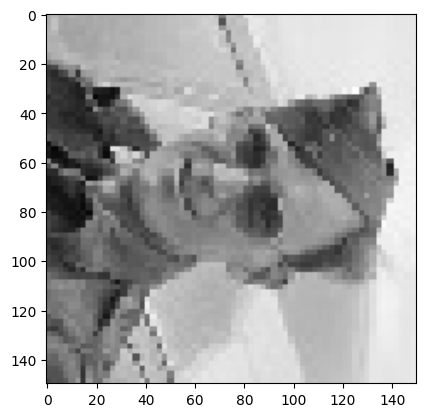

Predicted class: rotated_left


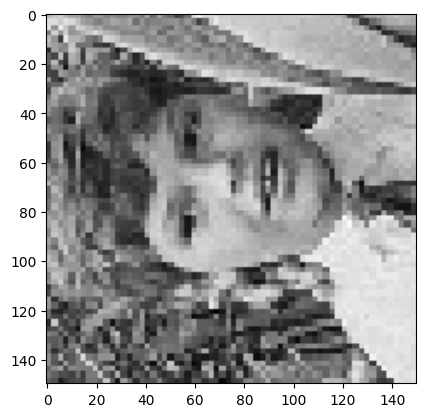

Predicted class: rotated_left


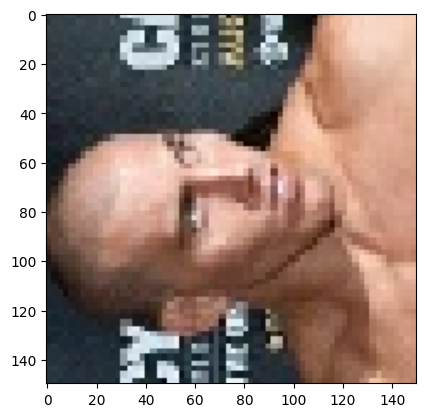

Predicted class: rotated_left


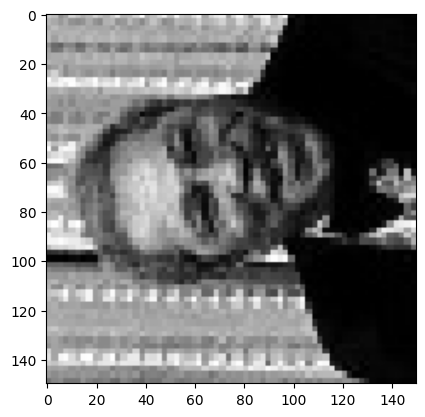

Predicted class: rotated_right


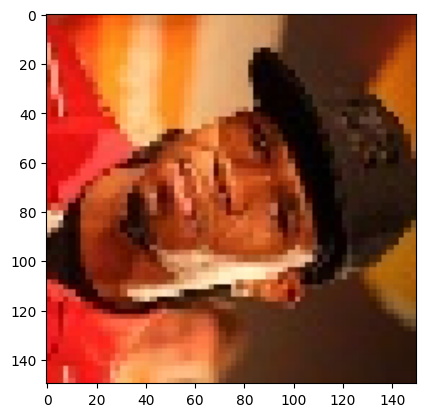

Predicted class: upside_down


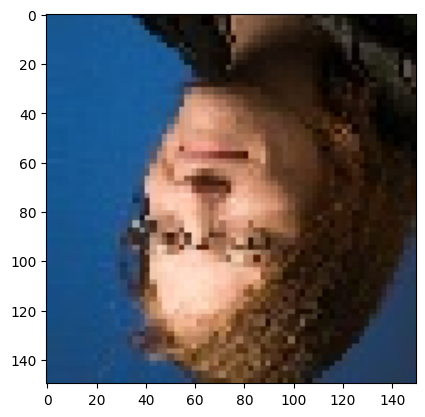

Predicted class: upright


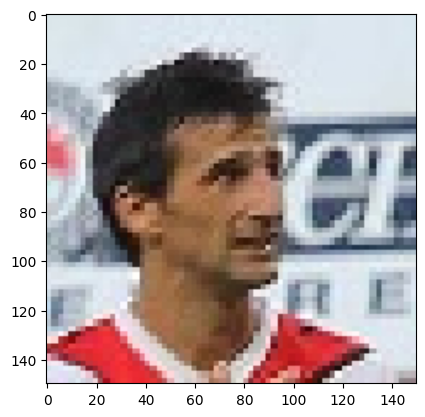

Predicted class: upright


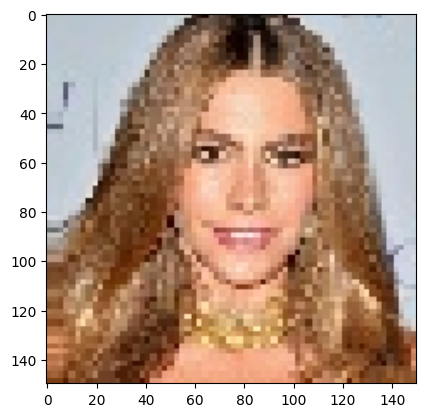

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Assuming you already have paths and y_pred populated
images = []
for path in paths[:20]:
    img_path = path
    img = image.load_img(img_path, target_size=(150, 150))
    x = image.img_to_array(img)
    images.append(x / 255.)  # Normalize the image

# Print predicted labels and display images for the first 20 predictions
for I, y in zip(images, y_pred[:20]):
    print(f"Predicted class: {y}")  # y is already the predicted label
    plt.imshow(I)
    plt.show()


Predicted class: upside_down | Rotation angle: 180 degrees


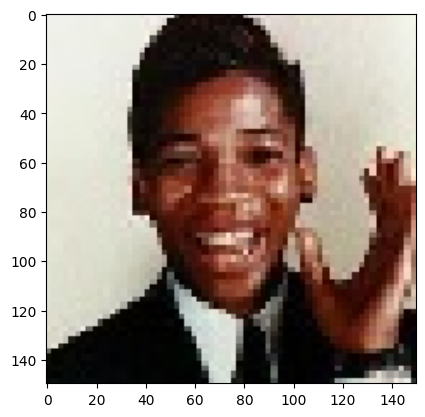

Predicted class: rotated_right | Rotation angle: 90 degrees


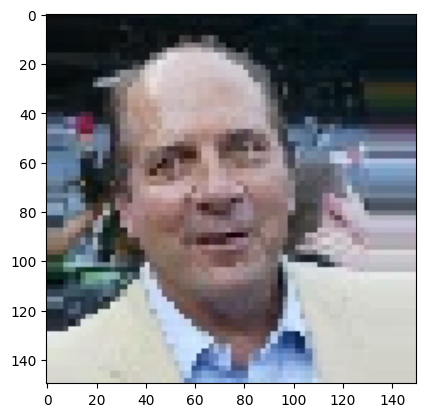

Predicted class: upright | Rotation angle: 0 degrees


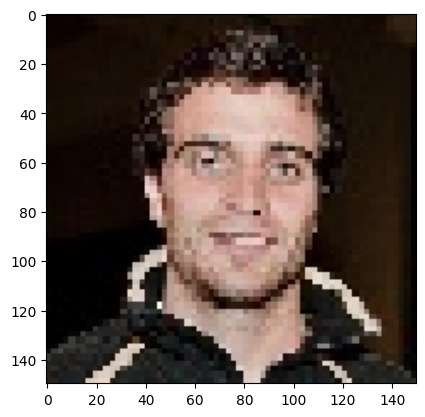

Predicted class: upside_down | Rotation angle: 180 degrees


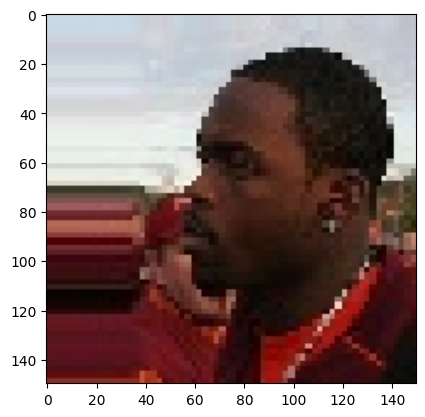

Predicted class: rotated_left | Rotation angle: 270 degrees


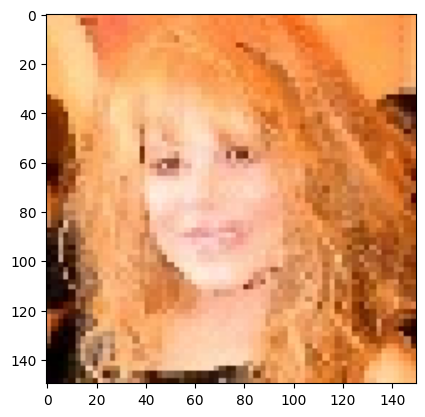

Predicted class: upside_down | Rotation angle: 180 degrees


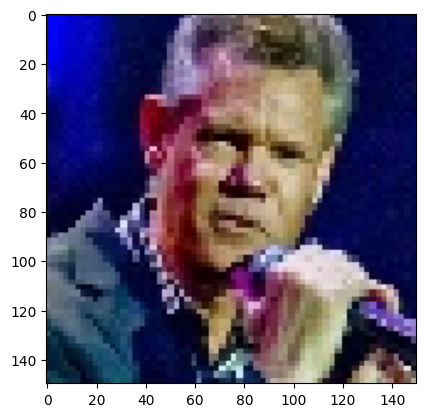

Predicted class: upright | Rotation angle: 0 degrees


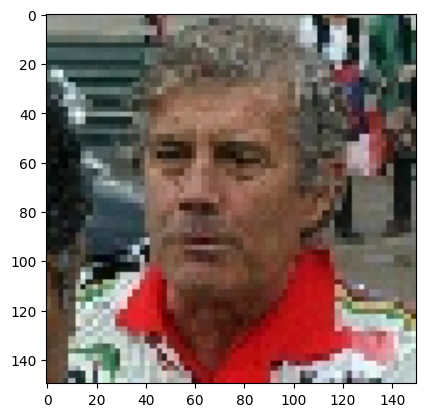

Predicted class: upright | Rotation angle: 0 degrees


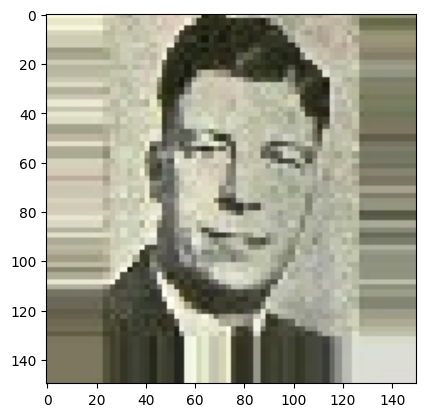

Predicted class: upright | Rotation angle: 0 degrees


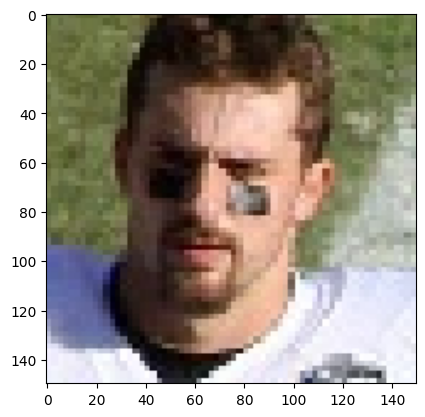

Predicted class: rotated_left | Rotation angle: 270 degrees


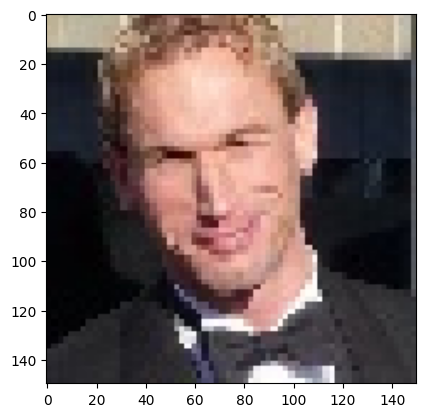

Predicted class: upside_down | Rotation angle: 180 degrees


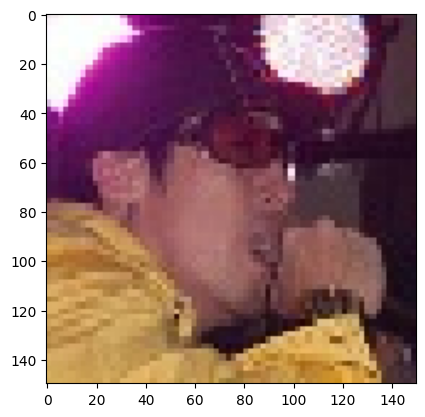

Predicted class: upright | Rotation angle: 0 degrees


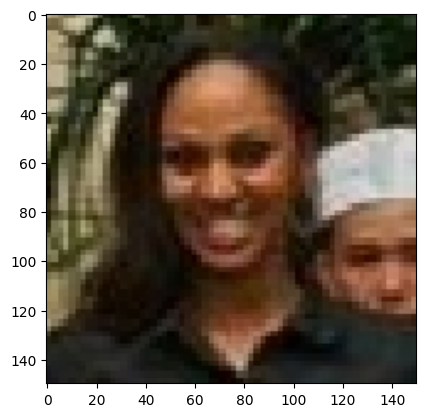

Predicted class: rotated_right | Rotation angle: 90 degrees


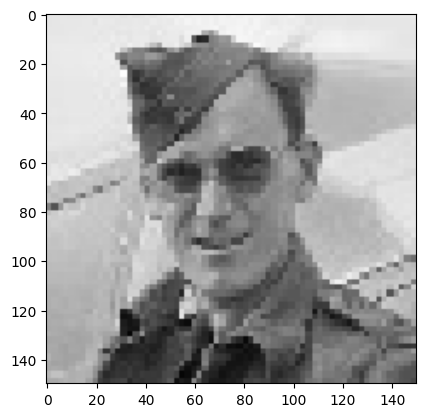

Predicted class: rotated_left | Rotation angle: 270 degrees


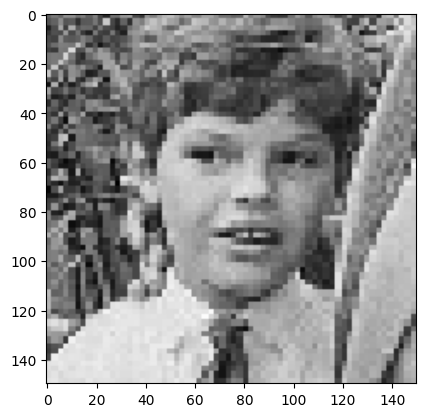

Predicted class: rotated_left | Rotation angle: 270 degrees


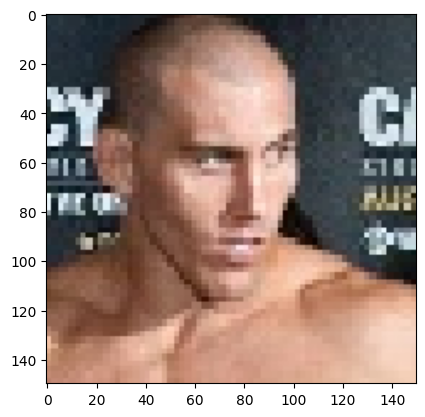

Predicted class: rotated_left | Rotation angle: 270 degrees


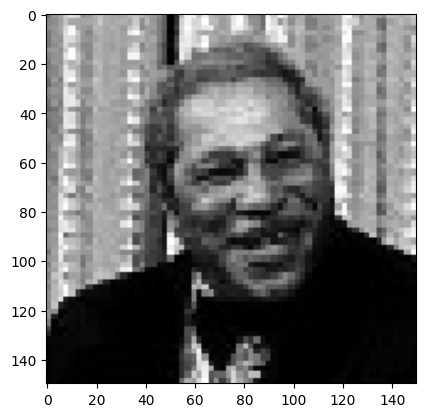

Predicted class: rotated_right | Rotation angle: 90 degrees


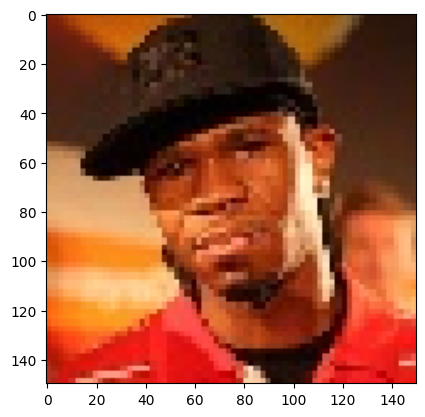

Predicted class: upside_down | Rotation angle: 180 degrees


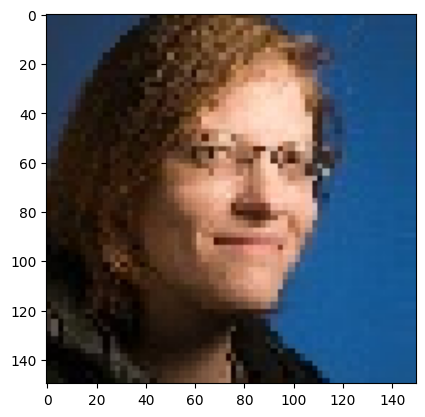

Predicted class: upright | Rotation angle: 0 degrees


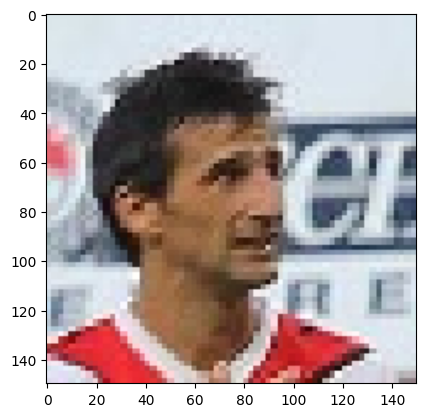

Predicted class: upright | Rotation angle: 0 degrees


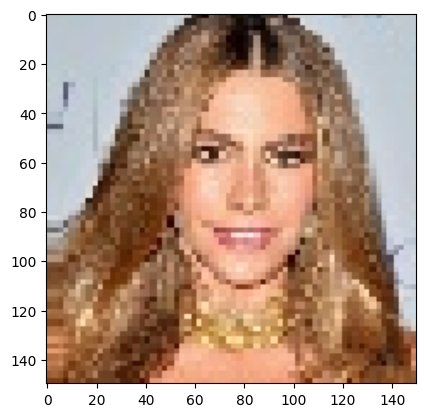

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image

# Assuming you already have paths and y_pred populated
images = []
for path in paths[:20]:
    img_path = path
    img = image.load_img(img_path, target_size=(150, 150))
    x = image.img_to_array(img)
    images.append(x / 255.)  # Normalize the image

# Map predictions to corresponding rotation angles
rotation_map = {
    'rotated_left': 270,    # Rotate 270 degrees counter-clockwise
    'rotated_right': 90,  # Rotate 90 degrees counter-clockwise
    'upright': 0,          # No rotation
    'upside_down': 180     # Rotate 180 degrees
}

# Show and rotate images based on predictions
for I, y in zip(images, y_pred[:20]):
    # Get the rotation angle based on the prediction
    rotation_angle = rotation_map[y]

    # Convert the image array back to a PIL image
    pil_img = Image.fromarray((I * 255).astype(np.uint8))

    # Rotate the image as per the predicted orientation
    rotated_img = pil_img.rotate(rotation_angle)

    # Display the rotated image
    print(f"Predicted class: {y} | Rotation angle: {rotation_angle} degrees")
    plt.imshow(rotated_img)
    plt.show()


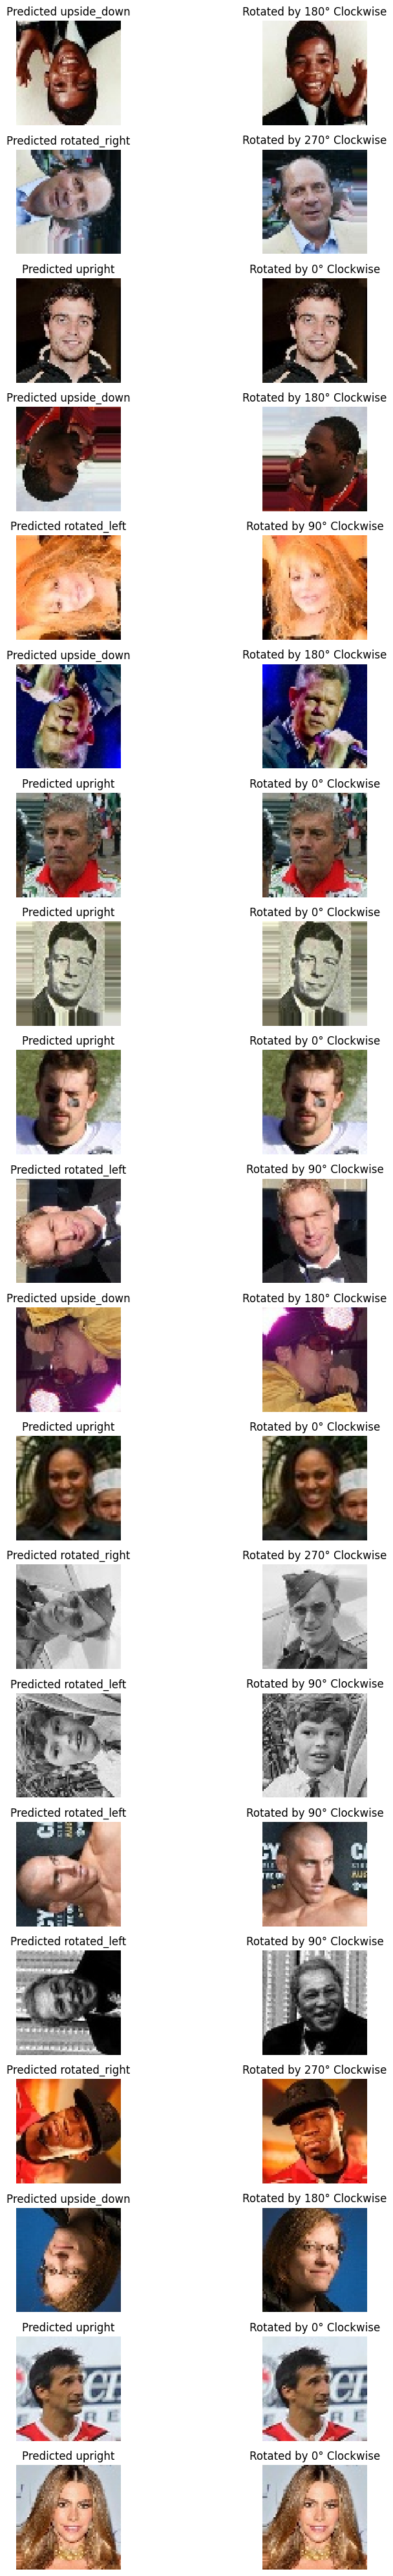

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image

# Assuming you already have paths and y_pred populated (class predictions from the model)
images = []
for path in paths[:20]:
    img_path = path
    img = image.load_img(img_path, target_size=(150, 150))
    x = image.img_to_array(img)
    images.append(x / 255.)  # Normalize the image

# Map predictions to corresponding rotation angles (clockwise)
rotation_map = {
    'rotated_left': 90,    # Rotate 90 degrees clockwise (left)
    'rotated_right': 270,   # Rotate 270 degrees clockwise (right)
    'upright': 0,          # No rotation
    'upside_down': 180     # Rotate 180 degrees clockwise
}

# Create a subplot layout with 20 rows and 2 columns (for original and rotated images)
fig, axes = plt.subplots(20, 2, figsize=(10, 40))  # 20 rows, 2 columns

# Show and rotate images based on predictions
for i, (I, y) in enumerate(zip(images, y_pred[:20])):
    # Get the rotation angle based on the prediction
    rotation_angle = rotation_map[y]

    # Convert the image array back to a PIL image
    pil_img = Image.fromarray((I * 255).astype(np.uint8))

    # Rotate the image as per the predicted orientation (clockwise)
    rotated_img = pil_img.rotate(-rotation_angle)  # Negative for clockwise rotation

    # Display the original image on the left column
    axes[i, 0].imshow(I)
    axes[i, 0].axis('off')  # Hide axes for cleaner display
    axes[i, 0].set_title(f"Predicted {y}")

    # Display the rotated image on the right column
    axes[i, 1].imshow(rotated_img)
    axes[i, 1].axis('off')  # Hide axes for cleaner display
    axes[i, 1].set_title(f"Rotated by {rotation_angle}° Clockwise")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image
import os

# Assuming you already have paths and y_pred populated (class predictions from the model)
images = []
for path in paths[:30]:
    img_path = path
    img = image.load_img(img_path, target_size=(150, 150))
    x = image.img_to_array(img)
    images.append(x / 255.)  # Normalize the image

# Map predictions to corresponding rotation angles (clockwise)
rotation_map = {
    'rotated_left': 90,    # Rotate 90 degrees clockwise (left)
    'rotated_right': 270,   # Rotate 270 degrees clockwise (right)
    'upright': 0,          # No rotation
    'upside_down': 180     # Rotate 180 degrees clockwise
}

# Directory to save the images
output_dir = 'rotated_images_output'
os.makedirs(output_dir, exist_ok=True)

# Process and save the images
for i, (I, y) in enumerate(zip(images, y_pred[:30])):
    # Get the rotation angle based on the prediction
    rotation_angle = rotation_map[y]

    # Convert the image array back to a PIL image
    pil_img = Image.fromarray((I * 255).astype(np.uint8))

    # Rotate the image as per the predicted orientation (clockwise)
    rotated_img = pil_img.rotate(-rotation_angle)  # Negative for clockwise rotation

    # Save the original image
    original_img_path = os.path.join(output_dir, f"original_{i+1}_{y}.png")
    pil_img.save(original_img_path)

    # Save the rotated image
    rotated_img_path = os.path.join(output_dir, f"rotated_{i+1}_{y}_{rotation_angle}deg.png")
    rotated_img.save(rotated_img_path)

    # Optionally, print the paths where the images were saved
    print(f"Saved: {original_img_path}")
    print(f"Saved: {rotated_img_path}")


Saved: rotated_images_output/original_1_upside_down.png
Saved: rotated_images_output/rotated_1_upside_down_180deg.png
Saved: rotated_images_output/original_2_rotated_right.png
Saved: rotated_images_output/rotated_2_rotated_right_270deg.png
Saved: rotated_images_output/original_3_upright.png
Saved: rotated_images_output/rotated_3_upright_0deg.png
Saved: rotated_images_output/original_4_upside_down.png
Saved: rotated_images_output/rotated_4_upside_down_180deg.png
Saved: rotated_images_output/original_5_rotated_left.png
Saved: rotated_images_output/rotated_5_rotated_left_90deg.png
Saved: rotated_images_output/original_6_upside_down.png
Saved: rotated_images_output/rotated_6_upside_down_180deg.png
Saved: rotated_images_output/original_7_upright.png
Saved: rotated_images_output/rotated_7_upright_0deg.png
Saved: rotated_images_output/original_8_upright.png
Saved: rotated_images_output/rotated_8_upright_0deg.png
Saved: rotated_images_output/original_9_upright.png
Saved: rotated_images_output/

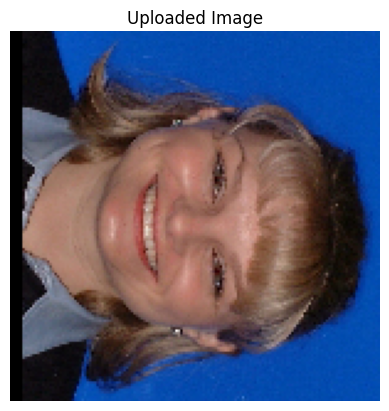

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted Orientation: rotated_right


'rotated_right'

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image


# Define the labels for the classes in the model
labels = ['rotated_left', 'rotated_right', 'upright', 'upside_down']  # Adjust if necessary

def predict_uploaded_image(uploaded_image_path):
    """
    This function takes an image path, processes the image,
    and uses the trained model to predict its orientation.
    """
    # Load and resize the image to the input size expected by the model
    img = image.load_img(uploaded_image_path, target_size=(150, 150))

    # Display the uploaded image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Uploaded Image")
    plt.show()

    # Preprocess image for the model
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to match training preprocessing

    # Make a prediction
    predictions = model.predict(img_array)
    predicted_class = labels[np.argmax(predictions)]  # Get the label with the highest probability

    # Display the result
    print(f"Predicted Orientation: {predicted_class}")
    return predicted_class

# Example usage:
# Replace 'path_to_uploaded_image.jpg' with the path to the uploaded image you want to test
predict_uploaded_image('/content/Rotate_Right_90_degrees.png')
